In [1]:
import math
import os
import re
import urllib

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from lxml import html
from matplotlib.colors import LogNorm
from rdkit import Chem

In [2]:
tqdm.tqdm = tqdm.tqdm_notebook

In [3]:
sns.set(style='white', rc={'axes.facecolor': (0, 0, 0, 0),
                            'font.family': 'serif'})
sns.set_context('paper', font_scale=2.5)

In [4]:
def get_num_spectrum_files(task_id, extension=None):
    with urllib.request.urlopen(f'https://proteomics2.ucsd.edu/ProteoSAFe/'
                                f'status.jsp?task={task_id}') as f_url:
        num_files_str = html.fromstring(f_url.read()).xpath(
            '//th[text()="Spectrum Files"]/following-sibling::td/'
            'descendant::*/text()')
        return sum([1 for line in num_files_str
                    if extension is None
                    or line.strip().lower().endswith(extension.lower())])

In [5]:
def inchi_to_smiles(inchi):
    try:
        mol = Chem.rdinchi.InchiToMol(inchi)[0]
    except ValueError:
        mol = None
    return Chem.MolToSmiles(mol, True) if mol is not None else None

In [6]:
def ridge_plot_scores(scores_df, num_files):
    palette = sns.color_palette('Blues_d', n_colors=len(
        scores_df['filename'].unique()))
    palette.reverse()
    fg = sns.FacetGrid(scores_df, row='filename', hue='filename',
                       height=0.5, aspect=15, palette=palette)

    fg.map(sns.kdeplot, 'score', shade=True, alpha=1., lw=1.5)
    fg.map(sns.kdeplot, 'score', color='white', lw=2.)
    fg.map(plt.axhline, y=0., lw=2.)

    for ax in fg.axes.ravel():
        ax.set_xlim(0.4, 1.)
    fg.set(xticks=np.arange(0.5, 1.05, 0.1))

    fg.axes[-1, 0].set_xlabel('Cosine score')
    fg.axes[len(fg.axes) // 2, 0].set_ylabel('Number of files')
    for ax, label, color in zip(fg.axes.ravel(), num_files, palette):
        ax.text(0, .2, label, color=color, ha='left', va='center',
                transform=ax.transAxes)

    fg.set_titles('')
    fg.set(yticks=[])
    fg.despine(bottom=True, left=True)

    fg.fig.subplots_adjust(hspace=-0.35)
    
    return fg

Process dataset ICL_breath_cancer_Study_1


/home/wout/.conda/envs/dorrestein/lib/python3.7/site-packages/seaborn/axisgrid.py:375: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  fig.tight_layout()
/home/wout/.conda/envs/dorrestein/lib/python3.7/site-packages/seaborn/axisgrid.py:848: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


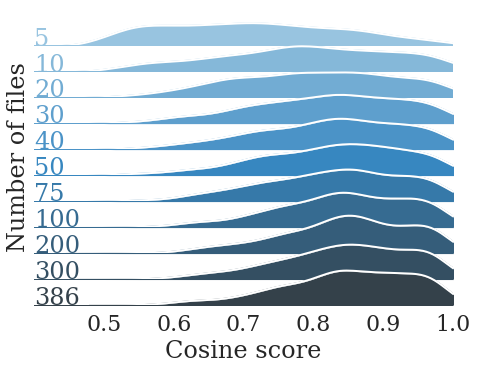

Process dataset UCDavis_combined


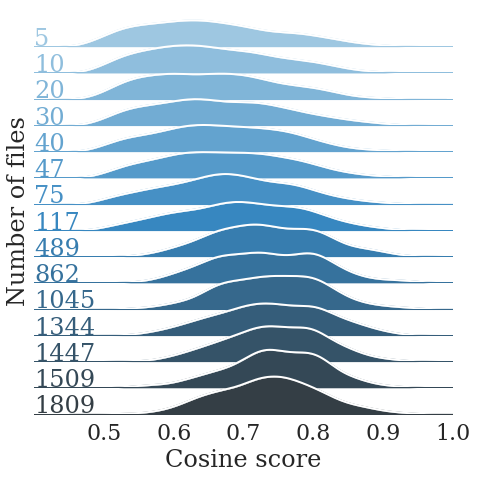

In [7]:
for data_dir in ['../data/ICL_breath_cancer_Study_1',
                 '../data/UCDavis_combined']:
    dataset = data_dir[data_dir.rfind('/') + 1:]
    metadata = (pd.read_csv(os.path.join(data_dir, 'metadata.csv'))
                .dropna(subset=['GNPS deconvolution link',
                                'GNPS library search link']))
    print(f'Process dataset {dataset}')
    
    # Get all identifications for this dataset.
    filenames_search, compounds = [], []
    for library_link in tqdm.tqdm(metadata['GNPS library search link'],
                                  'Files loaded', unit='files'):
        task_id = library_link[library_link.rfind('=') + 1:][:8]
        filename = (f'MOLECULAR-LIBRARYSEARCH-GC-{task_id}'
                    f'-view_all_annotations_DB-main.tsv')
        filenames_search.append(filename)
        compounds_file = (pd.read_csv(os.path.join(data_dir, filename),
                                      sep='\t',
                                      usecols=['#Scan#', 'INCHI', 'MQScore'],
                                      skipinitialspace=True)
                          .dropna())
        compounds_file['SMILES'] =\
            compounds_file['INCHI'].apply(inchi_to_smiles)
        compounds_file = compounds_file.drop('INCHI', 'columns').dropna()
        compounds.append(compounds_file)
    
    # Get the number of files for this dataset.
    num_files = [
        get_num_spectrum_files(
            deconvolution_link[deconvolution_link.rfind('=') + 1:], '.cdf')
        for deconvolution_link in metadata['GNPS deconvolution link']
    ]
    
#     # Plot the score distribution for this dataset.
#     for top in (1, 10):
#         filenames_top, scores_top = [], []
#         for filename, compounds_file in zip(filenames_search, compounds):
#             compounds_top = (
#                 compounds_file.sort_values(['#Scan#', 'MQScore'],
#                                            ascending=[True, False])
#                 .groupby('#Scan#').head(top))
#             filenames_top.extend([filename] * len(compounds_top))
#             scores_top.extend(compounds_top['MQScore'])
        
#         ridge_plot_scores(pd.DataFrame(data={'filename': filenames_top,
#                                              'score': scores_top}),
#                           num_files)

#         plt.savefig(f'cosine_distribution_{dataset}_top{top}.png', dpi=300)
#         plt.show()
#         plt.close()
    # Final figure for the manuscript.
    top = 1
    filenames_top, scores_top = [], []
    for filename, compounds_file in zip(filenames_search, compounds):
        compounds_top = (
            compounds_file.sort_values(['#Scan#', 'MQScore'],
                                       ascending=[True, False])
            .groupby('#Scan#').head(top))
        filenames_top.extend([filename] * len(compounds_top))
        scores_top.extend(compounds_top['MQScore'])

    ridge_plot_scores(pd.DataFrame(data={'filename': filenames_top,
                                         'score': scores_top}),
                      num_files)

    plt.savefig(f'cosine_distribution_{dataset}_top{top}.svg', dpi=300)
    plt.show()
    plt.close()